In [1]:
import pandas as pd
from pandas import json_normalize
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import numpy as np
from matplotlib.patches import FancyArrowPatch

In [2]:
#scegliamo di analizzare la stagione 2015/2016 e la partita
competition_id = 12
season_id = 27
match_id = 3879610

In [3]:
matches = requests.get("https://raw.githubusercontent.com/statsbomb/open-data/refs/heads/master/data/matches/"+str(competition_id)+"/"+str(season_id)+".json")
matches = matches.json()

asroma = "AS Roma"

for match in matches:
    if match['match_id'] == match_id:
        print(match['home_team']['home_team_name'],"-", match['away_team']['away_team_name'],
          str(match['home_score']) , ":" , str(match['away_score']) , "(match_id: " , str(match['match_id']) , ")")

AS Roma - Lazio 2 : 0 (match_id:  3879610 )


In [4]:
events = requests.get("https://raw.githubusercontent.com/statsbomb/open-data/refs/heads/master/data/events/"+str(match_id)+".json")
events = events.json()
match_events = json_normalize(events, sep="_")
pd.set_option("display.max.columns",None)

# esaminiamo i tiri
asroma_shots = match_events.loc[(match_events["type_name"] == "Shot") & (match_events["team_name"] == asroma)]

#passaggi
asroma_passes = match_events.loc[(match_events["type_name"] == "Pass") & (match_events["team_name"] == asroma)].loc[match_events["pass_type_name"] != "Throw-in"]

In [5]:
shots_outcome = asroma_shots["shot_outcome_name"].unique()
outcome_counts = asroma_shots["shot_outcome_name"].value_counts()
outcome_counts

shot_outcome_name
Blocked    5
Off T      4
Goal       2
Wayward    2
Post       1
Name: count, dtype: int64

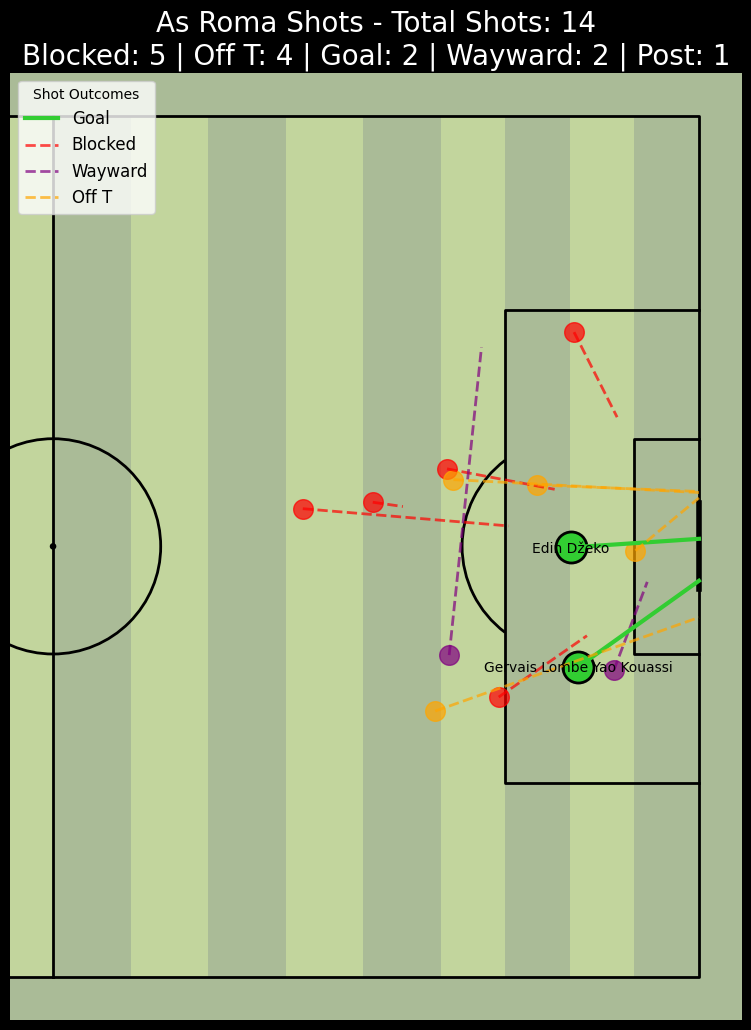

In [6]:
# Calcolare il numero di tiri e gol
total_shots = len(asroma_shots)  # Totale tiri
goals = len(asroma_shots[asroma_shots["shot_outcome_name"] == "Goal"])  # Gol fatti

# Calcolare il numero di tiri per ogni tipo di outcome
outcome_counts = asroma_shots["shot_outcome_name"].value_counts()

# Creazione del grafico
fig, ax = plt.subplots(figsize=(15.6, 10.4))
fig.set_facecolor("black")
ax.patch.set_facecolor("black")

# Disegnare il campo
#pitch = Pitch(line_color='black', pitch_color='#aabb97', stripe_color='#c2d59d', stripe=True, pitch_length=140, pitch_width=100)

pitch = Pitch(line_color='black', pitch_color='#aabb97', stripe_color='#c2d59d', stripe=True,
                            half=True, pitch_length=100, pitch_width=70)  # Campo metà e verticale
pitch.draw(ax=ax)

# Colori per ogni tipo di tiro sbagliato
missed_outcomes_colors = {
    "Blocked": "red", 
    "Off T": "orange", 
    "Wayward": "purple", 
    "Saved": "yellow",  
    "Saved to Post": "blue"
}

# Linee tratteggiate per i tiri sbagliati
line_style = "--"  # Linea tratteggiata per tutti i tiri sbagliati

# Creare una lista per le etichette della legenda
legend_labels = []
legend_lines = []

# Disegnare i tiri
for x in range(len(asroma_shots["id"])):
    outcome = asroma_shots["shot_outcome_name"].iloc[x]
    if outcome == "Goal":
        # Disegnare la linea del tiro per i gol (linea verde continua, enfatizzata)
        line, = plt.plot(
            (asroma_shots["location"].iloc[x][0], asroma_shots["shot_end_location"].iloc[x][0]),
            (asroma_shots["location"].iloc[x][1], asroma_shots["shot_end_location"].iloc[x][1]),
            color="limegreen", linestyle='-', linewidth=3)  # Spessore aumentato per enfatizzare
        # Cerchio più grande e luminoso per i gol
        plt.scatter(asroma_shots["location"].iloc[x][0], asroma_shots["location"].iloc[x][1], color="limegreen", s=500, edgecolors="black", linewidth=2)

        # Aggiungi il nome del giocatore che ha segnato
        player_name = asroma_shots["player_name"].iloc[x]
        plt.text(asroma_shots["location"].iloc[x][0], asroma_shots["location"].iloc[x][1]+0.5,  # Posizione del testo
                 player_name, color="black", fontsize=10, ha="center")

        # Aggiungere la linea per la legenda (linea verde continua per i gol)
        if "Goal" not in legend_labels:
            legend_labels.append("Goal")
            legend_lines.append(line)

    elif outcome in missed_outcomes_colors:
        # Per i tiri sbagliati, assegniamo il colore e la linea tratteggiata
        color = missed_outcomes_colors[outcome]
        line, = plt.plot(
            (asroma_shots["location"].iloc[x][0], asroma_shots["shot_end_location"].iloc[x][0]),
            (asroma_shots["location"].iloc[x][1], asroma_shots["shot_end_location"].iloc[x][1]),
            color=color, linestyle=line_style, linewidth=2, alpha=0.7)
        plt.scatter(asroma_shots["location"].iloc[x][0], asroma_shots["location"].iloc[x][1], color=color, s=200, alpha=0.7)

        # Aggiungere la linea per la legenda per il tipo di tiro sbagliato
        if outcome not in legend_labels:
            legend_labels.append(outcome)
            legend_lines.append(line)

# Creare la stringa per il titolo con il conteggio di ciascun tipo di tiro
outcome_title = ' | '.join([f"{outcome}: {count}" for outcome, count in outcome_counts.items()])

# Aggiungere il titolo con il numero di tiri e gol, oltre al conteggio per ogni tipo di tiro
plt.title(f"As Roma Shots - Total Shots: {total_shots}\n{outcome_title}", color="white", size=20)

# Aggiungere la legenda con le etichette
plt.legend(legend_lines, legend_labels, loc="upper left", fontsize=12, title="Shot Outcomes")

# Layout e visualizzazione
plt.tight_layout()
plt.show()


In [7]:
# Filtra solo gli eventi della Roma
roma_events = match_events[match_events['team_name'] == 'AS Roma']

# Trova tutti gli eventi che rappresentano un gol della Roma
goal_events = roma_events[roma_events['shot_outcome_name'] == 'Goal']

# Crea un dizionario per raccogliere gli eventi precedenti a ciascun gol
events_before_goals_dict = {}

# Per ogni gol trovato, seleziona gli eventi precedenti
for goal_event in goal_events.itertuples():
    # Trova l'indice dell'evento gol
    goal_event_index = goal_event.Index
    
    # Filtra gli eventi precedenti al gol
    events_before_goal = roma_events[roma_events.index <= goal_event_index]
    
    # Seleziona gli ultimi 10 eventi precedenti
    last_10_events = events_before_goal.tail(4)
    
    # Aggiungi al dizionario con la chiave come l'indice dell'evento gol
    events_before_goals_dict[goal_event_index] = last_10_events

# Mostra il dizionario contenente gli eventi precedenti a ciascun gol
for key,value in events_before_goals_dict.items():
    print(key,value["type_name"])


408 403    Ball Receipt*
404            Carry
407         Foul Won
408             Shot
Name: type_name, dtype: object
2219 2215             Pass
2216    Ball Receipt*
2217            Carry
2219             Shot
Name: type_name, dtype: object


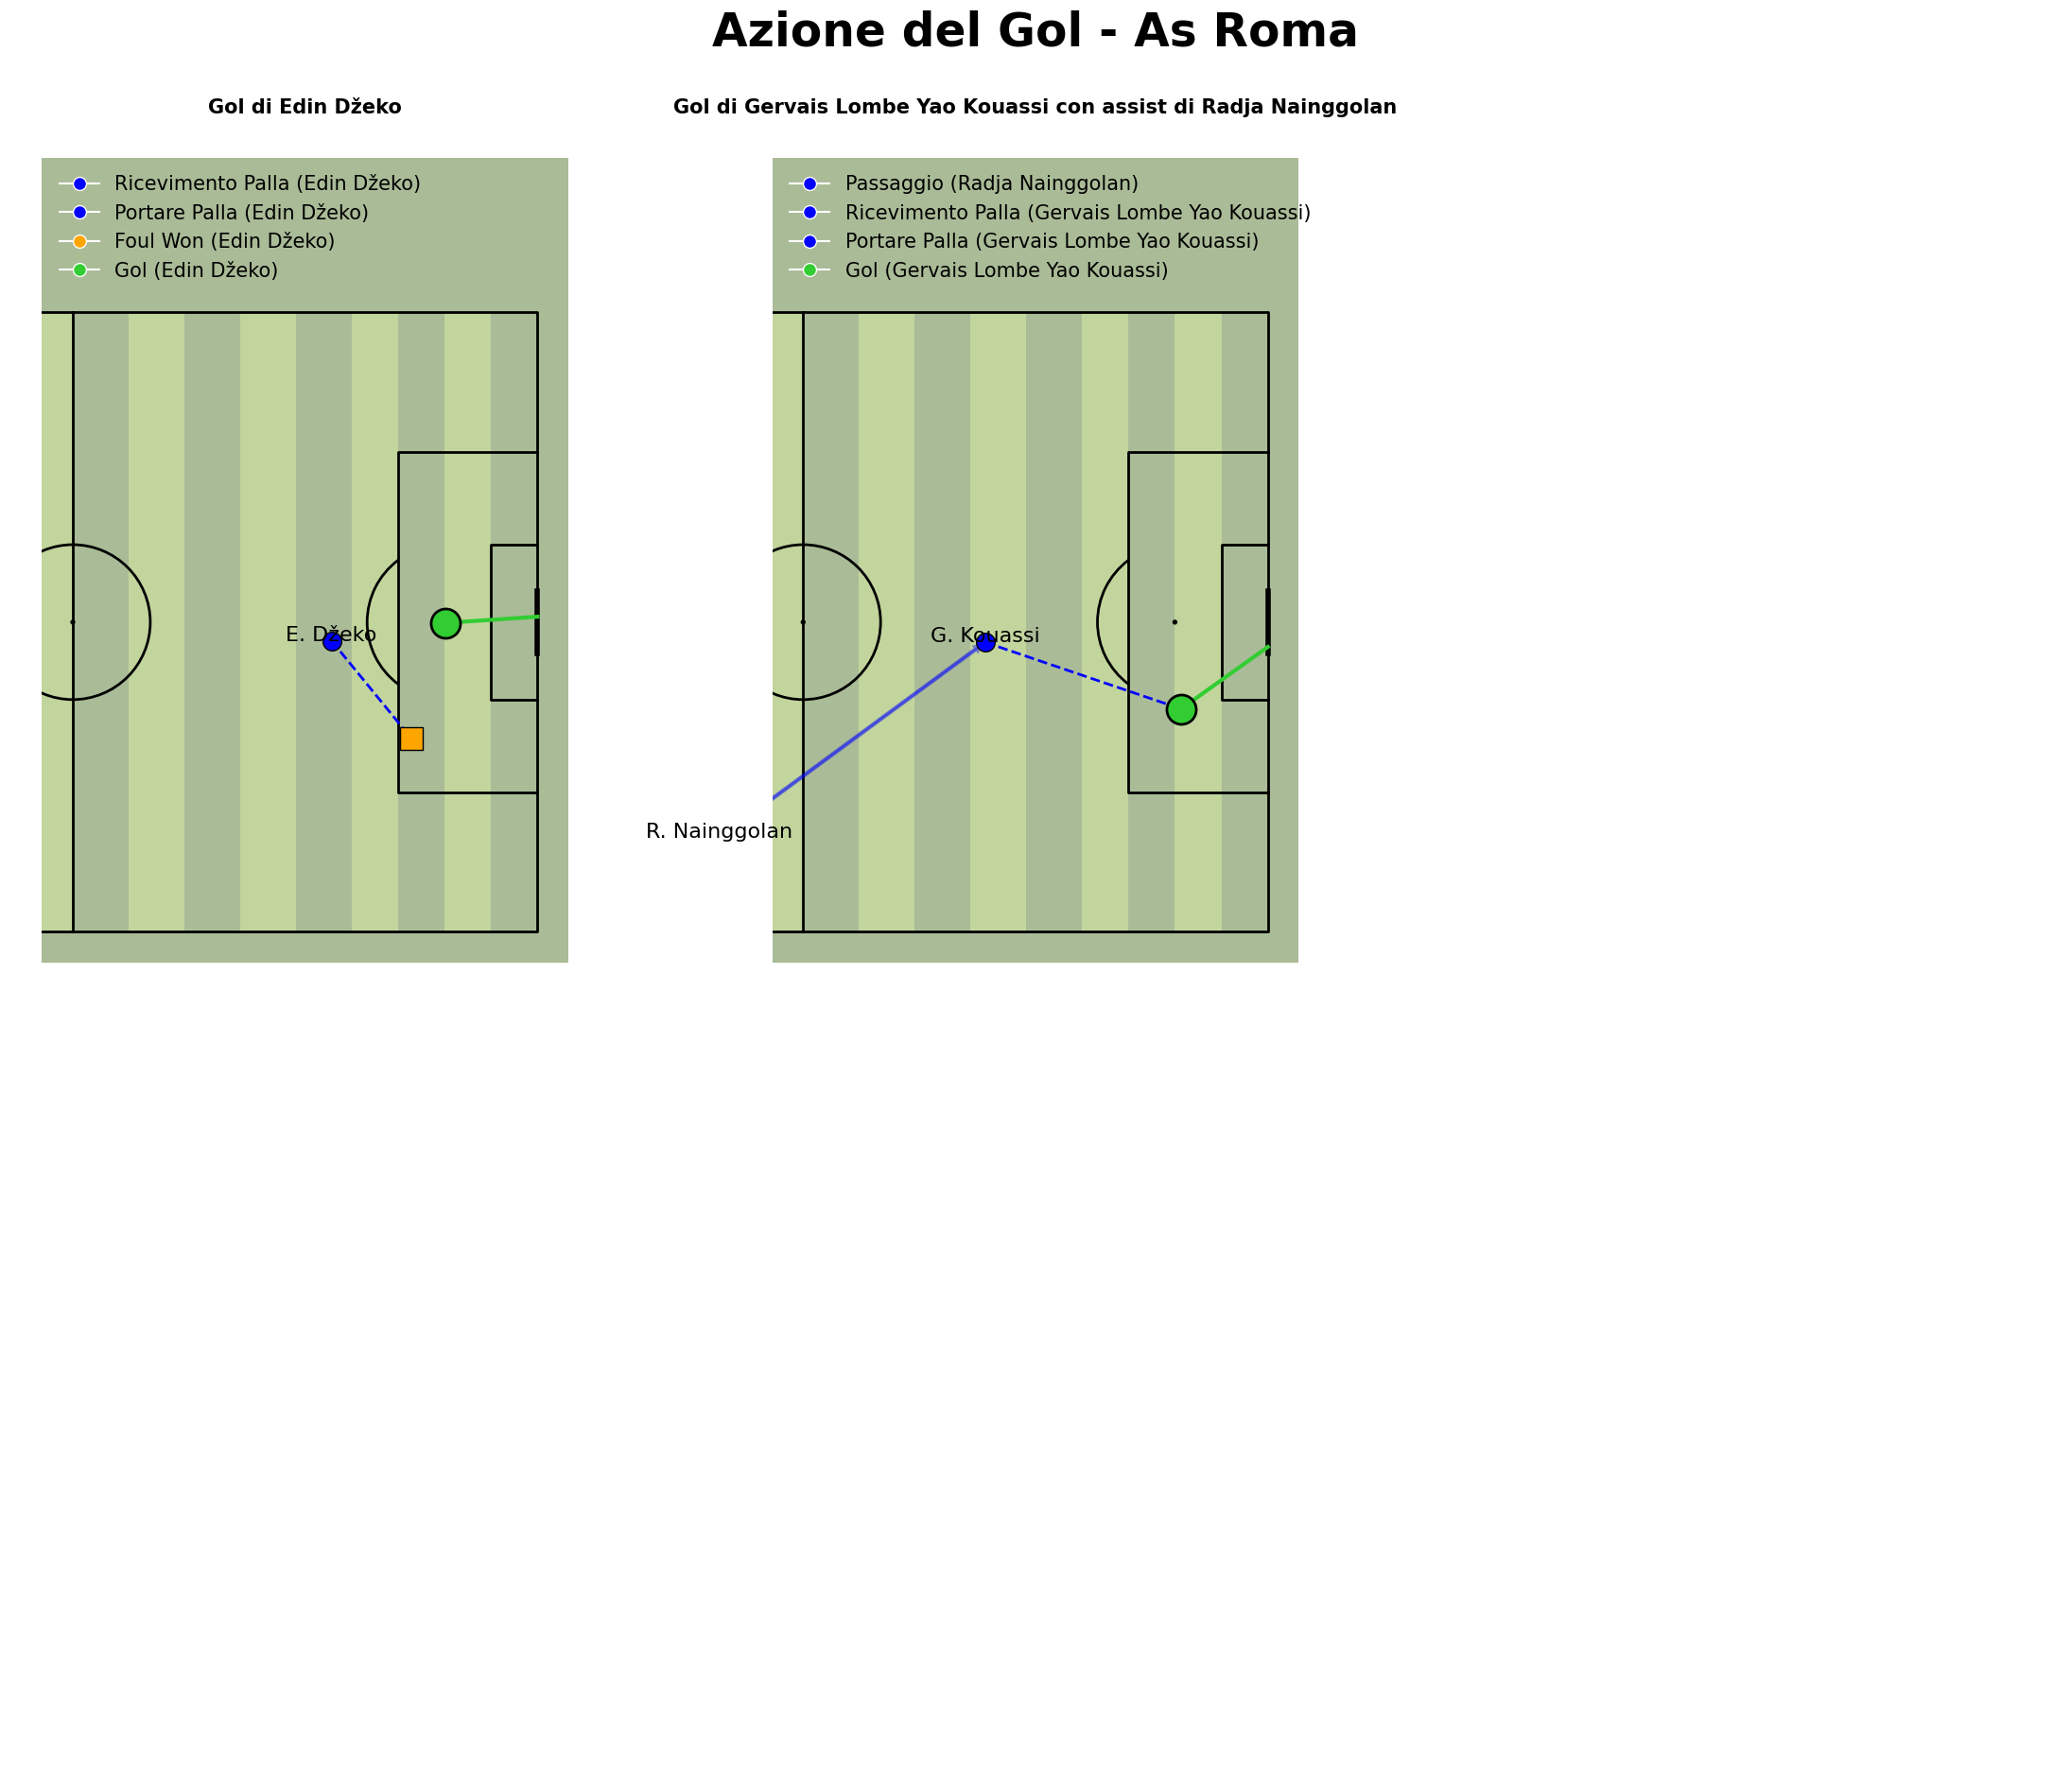

In [8]:
# Crea una figura con 16 sottotrame (4x4)
fig, axs = plt.subplots(figsize=(22, 18), nrows=2, ncols=3)

# Imposta il layout della figura
axs = axs.flatten()  # Rende più facile indicizzare le sottotrame

# Elenco dei passaggi considerati "sbagliati"
invalid_pass_outcomes = ["Incomplete", "Out", "Unknown", "Pass Offside", "Injury Clearance"]

# Variabile per limitare il numero di gol (max 6)
goal_counter = 0

# Crea il grafico per ogni gol nel dizionario
for goal_event_index, events_before_goal in events_before_goals_dict.items():
    # Prendi l'indice della sottotrama
    ax = axs[goal_counter]  # Ogni gol avrà una sottotrama separata

    # Crea il campo da gioco
    pitch = Pitch(line_color='black', pitch_color='#aabb97', stripe_color='#c2d59d', half=True, stripe=True, pad_top=20, pitch_length=140, pitch_width=100)
    pitch.draw(ax=ax)

    # Variabili per il nome del giocatore che ha segnato e per l'assist
    goal_scorer = None
    assist_provider = None

    # Variabile per tenere traccia del primo evento per ogni giocatore
    first_event = {}

    # Liste per raccogliere le etichette per la legenda
    legend_elements = []

    # Lista dei giocatori coinvolti negli eventi precedenti a questo gol
    players = events_before_goal['player_name'].unique()

    for player in players:
        player_events = events_before_goal[events_before_goal['player_name'] == player]

        # Estrai gli eventi del gol e disegna le azioni
        for index, row in player_events.iterrows():
            x = row['location'][0]
            y = row['location'][1]

            # Formattare il nome del giocatore: primo carattere del nome + punto + cognome intero
            player_name_formatted = f"{row['player_name'].split()[0][0]}. {row['player_name'].split()[-1]}"
            
            # Etichettiamo il giocatore solo al primo evento
            if player not in first_event:
                first_event[player] = True
                ax.text(x, y, f"{player_name_formatted}", fontsize=16, ha='center', color='black', zorder=4)

            # Se l'evento è un "Ball Recovery", tracciamo una X rossa
            if row['type_name'] == 'Ball Recovery':
                ax.text(x, y, 'X', fontsize=32, ha='center', color='red', va='center', fontweight='bold', zorder=3)
                if ('Ball Recovery', player) not in legend_elements:
                    legend_elements.append(('Recupero Palla', player, 'red'))

            # Se l'evento è un "Ball Receipt", disegniamo un nodo blu per il ricevimento della palla
            if row['type_name'] == 'Ball Receipt*':
                ax.scatter(x, y, color='blue', s=200, edgecolors='black', zorder=3)  # Nodo blu per il ricevimento
                if ('Ball Receipt*', player) not in legend_elements:
                    legend_elements.append(('Ricevimento Palla', player, 'blue'))
            
            # Se l'evento è un "Carry", tracciamo una linea tratteggiata
            if row['type_name'] == 'Carry':
                x_end, y_end = row["carry_end_location"]
                ax.plot([x, x_end], [y, y_end], color='blue', linestyle='--', lw=2, zorder=2)  # Linea tratteggiata
                if ('Carry', player) not in legend_elements:
                    legend_elements.append(('Portare Palla', player, 'blue'))

            if row["type_name"] == "Pass":
                x_end, y_end = row["pass_end_location"]
                ax.plot([x, x_end], [y, y_end], color='blue', lw=2, zorder=2, alpha=0.4)

                # Aggiungi le frecce per ogni passaggio usando FancyArrowPatch
                arrow = FancyArrowPatch(
                    (x, y), (x_end, y_end), 
                    mutation_scale=15,  # Scala della freccia
                    color='blue',       # Colore della freccia
                    lw=0.2,             # Spessore della linea
                    alpha=0.4,          # Trasparenza della freccia
                    zorder=2            # Livello di sovrapposizione
                )
                ax.add_patch(arrow)
                
                # Controlla se il passaggio è stato un assist
                if row.get("pass_goal_assist", False):  # Verifica se il passaggio è un assist
                    assist_provider = row['player_name']  # Memorizza il nome del giocatore che ha fatto l'assist
                    # Disegnare il triangolo verde per l'assist
                    ax.plot(x, y, marker='^', markersize=20, color='limegreen', markeredgecolor='black', zorder=3)
                    
                if ('Passaggio', player) not in legend_elements:
                    legend_elements.append(('Passaggio', player, 'blue'))
            
            # Se l'evento è un "Foul Won", disegniamo un quadrato arancione
            if row["type_name"] == "Foul Won":
                ax.scatter(x, y, color='orange', s=300, edgecolors='black', marker='s', zorder=3)  # Quadrato arancione
                if ('Foul Won', player) not in legend_elements:
                    legend_elements.append(('Foul Won', player, 'orange'))

            if row["type_name"] == "Shot":
                # Ottieni la posizione finale del tiro
                x_end = row["shot_end_location"][0]
                y_end = row["shot_end_location"][1]

                # Verifica se il tiro è stato un gol
                if row["shot_outcome_name"] == "Goal":
                    goal_scorer = row['player_name']  # Memorizza il nome del giocatore che ha segnato
                    shot_color = 'limegreen'  # Colore per il gol
                    # Disegnare la linea del tiro (limegreen per il gol)
                    ax.plot([x, x_end], [y, y_end], color=shot_color, linestyle='-', linewidth=3, zorder=3)

                    # Cerchio luminoso per il gol
                    ax.scatter(x, y, color=shot_color, s=500, edgecolors='black', linewidth=2, zorder=4)

                    # Aggiungere l'evento al dizionario per la legenda
                    if ('Gol', player) not in legend_elements:
                        legend_elements.append(('Gol', player, shot_color))
                
                else:
                    shot_color = 'green'  # Colore per i tiri non riusciti

                    # Disegnare la linea del tiro (verde normale per un tiro non riuscito)
                    ax.plot([x, x_end], [y, y_end], color=shot_color, linestyle='-', linewidth=2, zorder=2)

                    # Cerchio per il tiro non riuscito
                    ax.scatter(x, y, color=shot_color, s=300, edgecolors='black', linewidth=2, zorder=3)

                    # Aggiungere l'evento al dizionario per la legenda
                    if ('Tiro non riuscito', player) not in legend_elements:
                        legend_elements.append(('Tiro non riuscito', player, shot_color))

    # Aggiungere il nome del giocatore che ha segnato e il fornitore dell'assist (se presente)
    title = f"Gol di {goal_scorer}"
    if assist_provider:
        title += f" con assist di {assist_provider}"

    ax.text(0.5, 1.05, title, ha='center', va='bottom', fontsize=15, fontweight='bold', transform=ax.transAxes)

    # Aggiungere la legenda
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for _, _, color in legend_elements]
    labels = [f"{evento} ({giocatore})" for evento, giocatore, _ in legend_elements]
    ax.legend(handles=handles, labels=labels, loc='upper left', fontsize=15, frameon=False)

    goal_counter += 1  # Incrementa il contatore per i gol

# Nascondi gli assi non utilizzati
for j in range(goal_counter, len(axs)):
    axs[j].axis('off')  # Disabilita gli assi per le sottotrame non utilizzate

# Aggiungi il titolo all'intera figura
fig.text(0.5, 1.05, "Azione del Gol - As Roma", ha='center', va='top', fontsize=35, fontweight='bold')

plt.tight_layout()
plt.show()


In [9]:
asroma_passes["player_name"].value_counts()

player_name
Iago Falqué Silva             37
Antonio Rüdiger               37
Wojciech Szczęsny             37
William Vainqueur             36
Edin Džeko                    34
Konstantinos Manolas          34
Radja Nainggolan              33
Vassilis Torosidis            30
Lucas Digne                   26
Mohamed Salah                 26
Gervais Lombe Yao Kouassi     16
Alessandro Florenzi            8
Seydou Kéita                   4
Juan Manuel Iturbe Arévalo     1
Name: count, dtype: int64

In [10]:
# selezioniamo solo le colonne rilevanti
columns = asroma_passes.loc[:,["location","pass_end_location","player_name","pass_outcome_name"]]

# prendiamo la lista di tutti i giocatori che hanno effettuato un passaggio
# conta il numero di passaggi per ciascun giocatore
# players = df['player_name'].unique()
players = columns.groupby(by="player_name").size().sort_values(ascending=False).index.tolist()

columns["pass_outcome_name"].unique()

players

['Antonio Rüdiger',
 'Iago Falqué Silva',
 'Wojciech Szczęsny',
 'William Vainqueur',
 'Edin Džeko',
 'Konstantinos Manolas',
 'Radja Nainggolan',
 'Vassilis Torosidis',
 'Lucas Digne',
 'Mohamed Salah',
 'Gervais Lombe Yao Kouassi',
 'Alessandro Florenzi',
 'Seydou Kéita',
 'Juan Manuel Iturbe Arévalo']

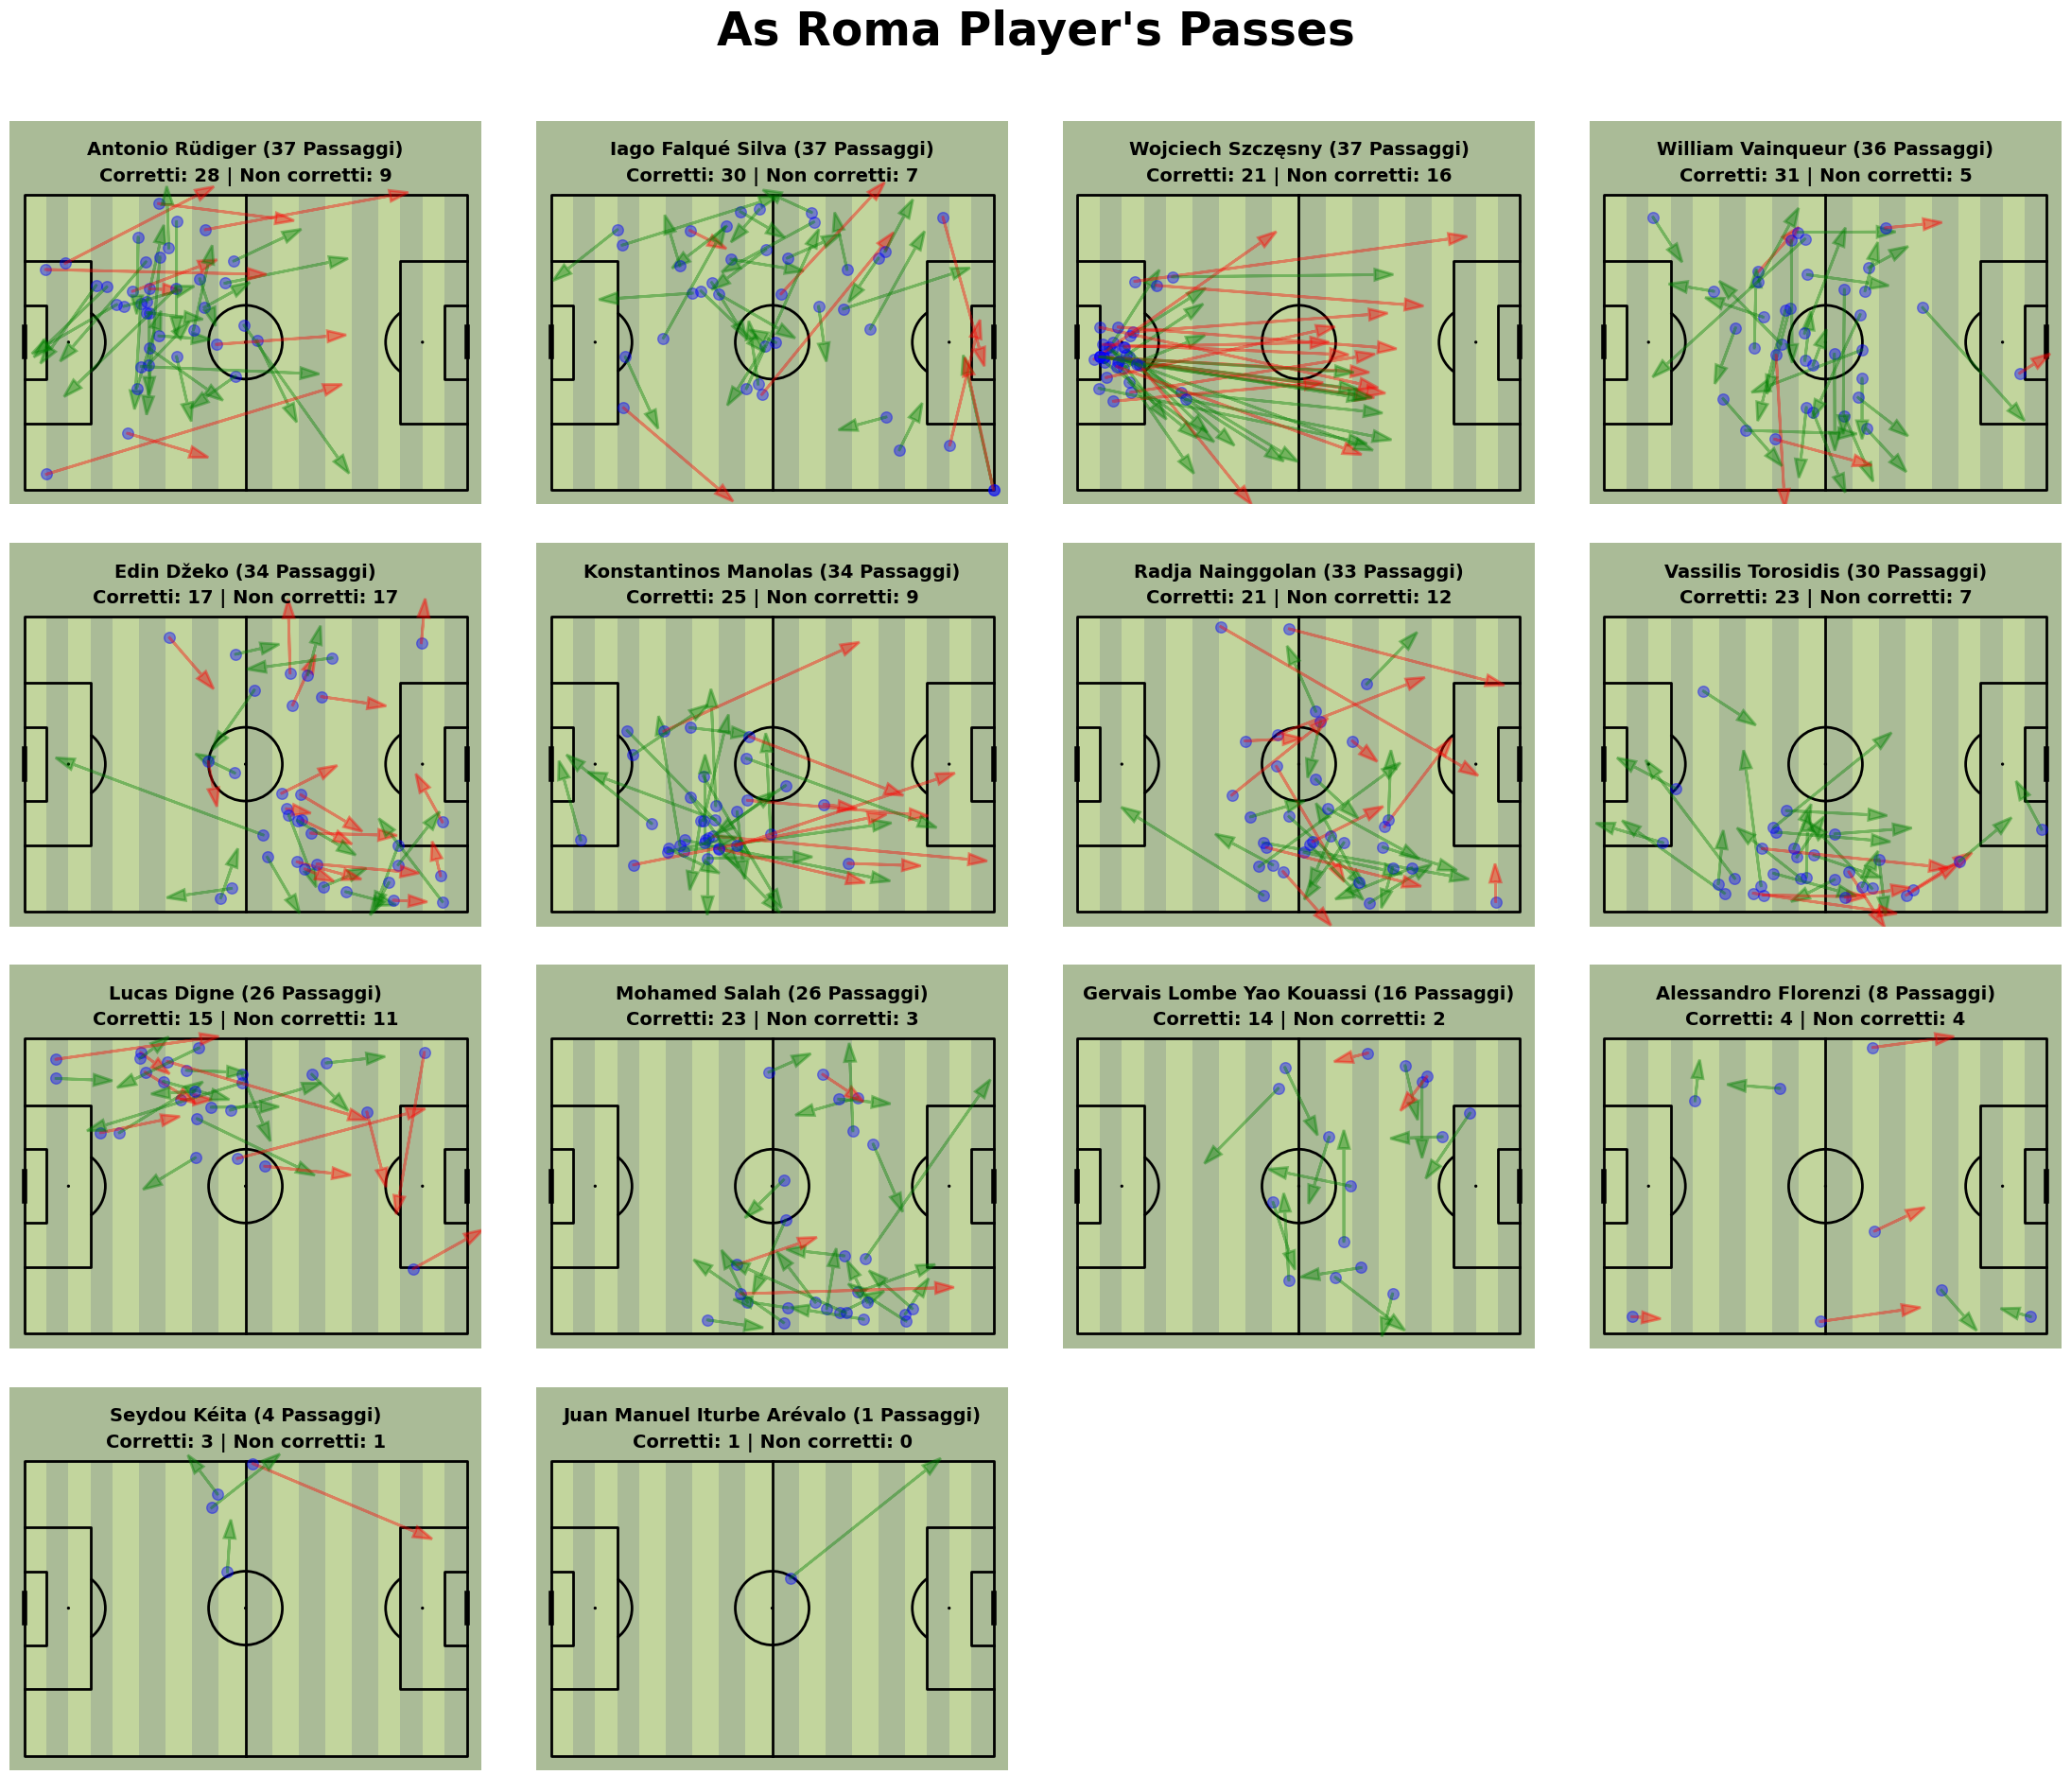

In [11]:
# Crea una figura con 16 sottotrame (4x4)
fig, axs = plt.subplots(figsize=(22, 18), nrows=4, ncols=4)

# Imposta il layout della figura
axs = axs.flatten()  # Rende più facile indicizzare le sottotrame

# Elenco dei passaggi considerati "sbagliati"
invalid_pass_outcomes = ["Incomplete", "Out", "Unknown", "Pass Offside", "Injury Clearance"]

# Disegna un campo da gioco per ciascun giocatore
for i, player in enumerate(players):
    
    # disegna un Pitch all'axs[i]
    pitch = Pitch(line_color='black', pitch_color='#aabb97', stripe_color='#c2d59d', stripe=True, pad_top=20,pitch_length=140, pitch_width=100)
    ax = axs[i]
    pitch.draw(ax=ax)
    
    player_df = columns[columns["player_name"] == player]

     # Calcola il numero di passaggi
    pass_count = len(player_df)

    # Calcola il numero di passaggi corretti e non corretti
    correct_passes = len(player_df[~player_df['pass_outcome_name'].isin(invalid_pass_outcomes)])
    incorrect_passes = len(player_df[player_df['pass_outcome_name'].isin(invalid_pass_outcomes)])
    
    # Aggiungi il nome del giocatore e il numero di passaggi sopra il campo
    ax.text(0.5, 0.9, f"{player} ({pass_count} Passaggi)", color='black', fontsize=14, ha='center', va='bottom', 
            transform=ax.transAxes, fontweight='bold')
    
    # Aggiungi il numero di passaggi corretti e non corretti sotto il titolo
    ax.text(0.5, 0.83, f"Corretti: {correct_passes} | Non corretti: {incorrect_passes}", color='black', fontsize=14, ha='center', va='bottom', 
            transform=ax.transAxes, fontweight='bold')

    player_df = columns[columns["player_name"] == player]

    # Estrai direttamente le coordinate e disegna le frecce
    for j in range(len(player_df)):
        # Estrai le coordinate in modo corretto con .iloc
        x_start, y_start = player_df['location'].iloc[j][0], player_df['location'].iloc[j][1]
        x_end, y_end = player_df['pass_end_location'].iloc[j][0], player_df['pass_end_location'].iloc[j][1]

        # Verifica se il passaggio è sbagliato
        pass_outcome = player_df['pass_outcome_name'].iloc[j]
        
        # Imposta il colore della freccia in base all'esito del passaggio
        if pass_outcome in invalid_pass_outcomes:
            arrow_color = 'red'  # Passaggio sbagliato
        else:
            arrow_color = 'green'  # Passaggio corretto
        
        # Aggiungi uno scatter per le posizioni di partenza e di arrivo dei passaggi
        ax.scatter(x_start, y_start, color='blue', alpha=0.4, s=70)
        
        # Aggiungi le frecce per ogni passaggio usando ax.arrow()
        ax.arrow(
            x_start, y_start,  # Coordinate di partenza
            x_end - x_start,   # Componente dx della freccia (differenza x)
            y_end - y_start,   # Componente dy della freccia (differenza y)
            head_width=3,      # Larghezza della testa della freccia
            head_length=5,     # Lunghezza della testa della freccia
            fc=arrow_color,        # Colore della freccia
            ec=arrow_color,        # Colore del bordo della freccia
            lw=2,              # Spessore della linea della freccia
            alpha=0.4          # Trasparenza della freccia
        )

# Nascondi gli assi non utilizzati
for j in range(len(players), len(axs)):
    axs[j].axis('off')  # Disabilita gli assi per le sottotrame non utilizzate

# Aggiungi il titolo all'intera figura
fig.text(0.5, 1.05, "As Roma Player's Passes", ha='center', va='top', fontsize=35, fontweight='bold')

plt.tight_layout()
plt.show()   



In [12]:
formazione = match_events.loc[:,"team_name":"tactics_formation"]
formazione = formazione[(formazione["team_name"] == asroma) & formazione["tactics_formation"].notna()]
modulo = "-".join(str(int(formazione.iloc[0,1])))
modulo

'4-2-3-1'

In [13]:
titolari = [player["player"]["name"] for player in match_events[match_events["team_name"] == asroma].iloc[0]["tactics_lineup"]]
#titolari = [f"{name.split()[0][0]}. {name.split()[-1]}" for name in titolari]
titolari

['Wojciech Szczęsny',
 'Vassilis Torosidis',
 'Konstantinos Manolas',
 'Antonio Rüdiger',
 'Lucas Digne',
 'Radja Nainggolan',
 'William Vainqueur',
 'Mohamed Salah',
 'Iago Falqué Silva',
 'Gervais Lombe Yao Kouassi',
 'Edin Džeko']

In [14]:
# selezioniamo solo le colonne rilevanti
columns = asroma_passes.loc[:,["location","pass_end_location","player_name","pass_outcome_name","pass_recipient_name"]]

# Aggiungi una colonna "is_starter" per verificare se il giocatore è titolare
columns['is_starter'] = columns['player_name'].apply(lambda x: x in titolari)

In [15]:
scatter_df = pd.DataFrame()
for i, name in enumerate(columns["player_name"].unique()):
    passx = columns.loc[columns["player_name"] == name]["location"].apply(lambda x: x[0]).to_numpy()

    recx = columns.loc[columns["pass_recipient_name"] == name]["pass_end_location"].apply(lambda x: x[0]).to_numpy()

    passy = columns.loc[columns["player_name"] == name]["location"].apply(lambda y: y[1]).to_numpy()

    recy = columns.loc[columns["pass_recipient_name"] == name]["pass_end_location"].apply(lambda y: y[1]).to_numpy()
    
    scatter_df.at[i, "player_name"] = name

    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = columns.loc[columns["player_name"] == name].count().iloc[0]
    # Aggiungi un campo per segnare se il giocatore è titolare
    scatter_df.at[i, "is_starter"] = name in titolari

#adjust the size of a circle so that the player who made more passes 
scatter_df['marker_size'] = (scatter_df["no"] / scatter_df["no"].max() * 1500)
#counting passes between players
#columns["pair_key"] = columns.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)

#columns["pair_key"] = ["_".join(sorted([player, recipient])) for player, recipient in zip(columns["player_name"], columns["pass_recipient_name"])]

# Concatenare direttamente i valori senza ordinare e senza gestire i NaN manualmente
columns["pair_key"] = columns["player_name"].fillna('') + "_" + columns["pass_recipient_name"].fillna('')

lines_df = columns.groupby(["pair_key"]).count().reset_index()
lines_df.rename({'location':'pass_count'}, axis='columns', inplace=True)
#setting a threshold. You can try to investigate how it changes when you change it.
linesAll_df = lines_df[lines_df['pass_count']>2]
linesAll_df = linesAll_df.sort_values(by='pass_count', ascending=False)
linesAll_df


,pair_key,pass_count,pass_end_location,player_name,pass_outcome_name,pass_recipient_name,is_starter
113,Wojciech Szczęsny_Edin Džeko,17,17,17,8,17,17
57,Lucas Digne_,8,8,8,8,0,8
20,Edin Džeko_Mohamed Salah,8,8,8,3,8,8
49,Konstantinos Manolas_Edin Džeko,8,8,8,3,8,8
77,Radja Nainggolan_Edin Džeko,8,8,8,5,8,8
67,Mohamed Salah_Edin Džeko,8,8,8,2,8,8
16,Edin Džeko_Alessandro Florenzi,7,7,7,5,7,7
8,Antonio Rüdiger_Konstantinos Manolas,7,7,7,0,7,7
13,Antonio Rüdiger_William Vainqueur,6,6,6,1,6,6
54,Konstantinos Manolas_Vassilis Torosidis,6,6,6,0,6,6


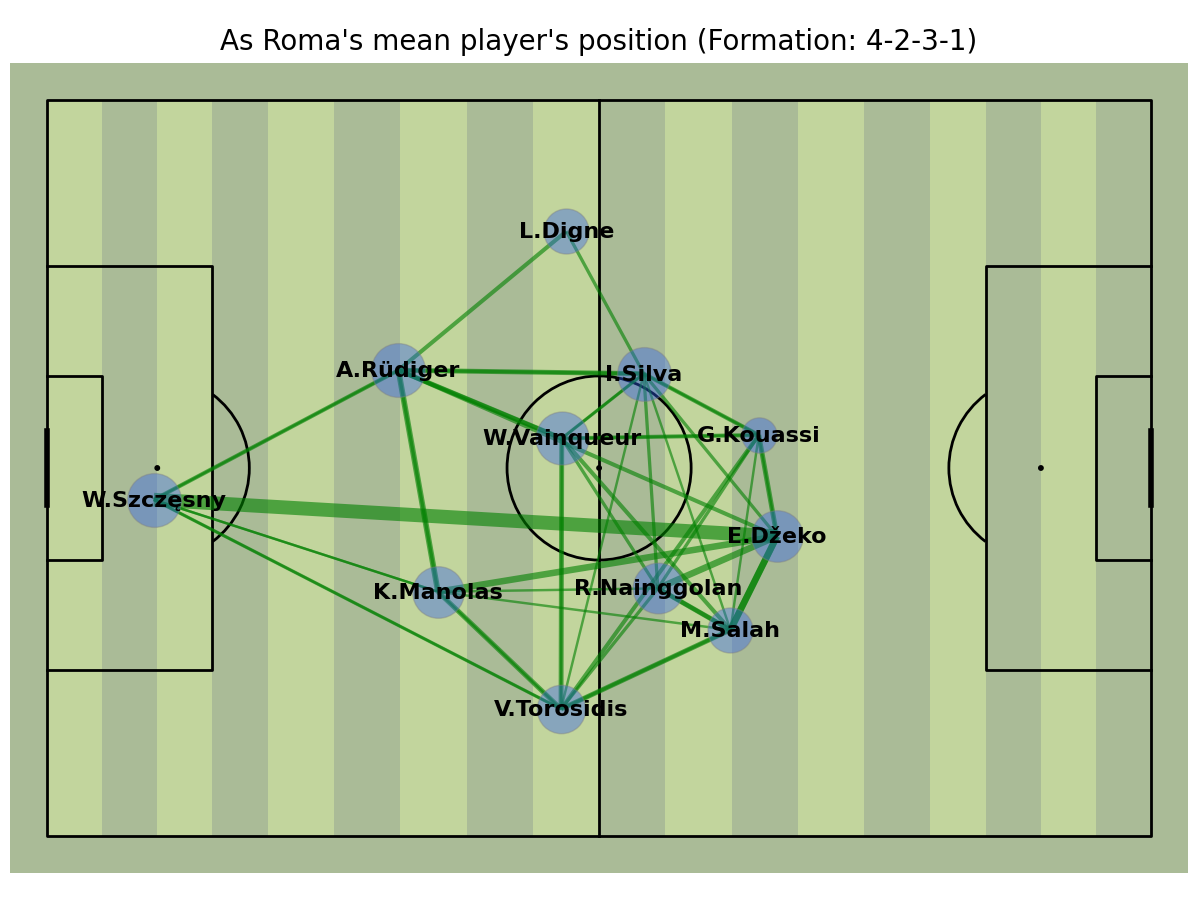

In [16]:
#Drawing pitch
pitch = Pitch(line_color='black',pitch_color='#aabb97',stripe_color='#c2d59d',stripe=True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#annotating player name
for i, row in scatter_df.iterrows():
    if row.is_starter:
        pitch.scatter(row.x, row.y, s=row.marker_size, color='#2f5fed', edgecolors='grey', linewidth=1, alpha=0.4, ax=ax["pitch"], zorder=3)
        short_name = row.player_name.split()[0][0] + "." + row.player_name.split()[-1]
        pitch.annotate(short_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

# Loop through the passes and draw lines between players who are both present in scatter_df
for i, row in linesAll_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]

    if player1 != "" and player2 != "" and player1 in titolari and player2 in titolari:
        # Extract coordinates for player1
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]

        # Extract coordinates for player2
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]

        # Get the number of passes between the two players
        num_passes = row["pass_count"]

        # Adjust the line width based on the number of passes
        line_width = (num_passes / lines_df['pass_count'].max() * 10)

        # Draw the line between player1 and player2
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=0.6, lw=line_width, zorder=2, color="green", ax=ax["pitch"])

fig.suptitle(f"As Roma's mean player's position (Formation: {modulo})", fontsize=20)
plt.show()

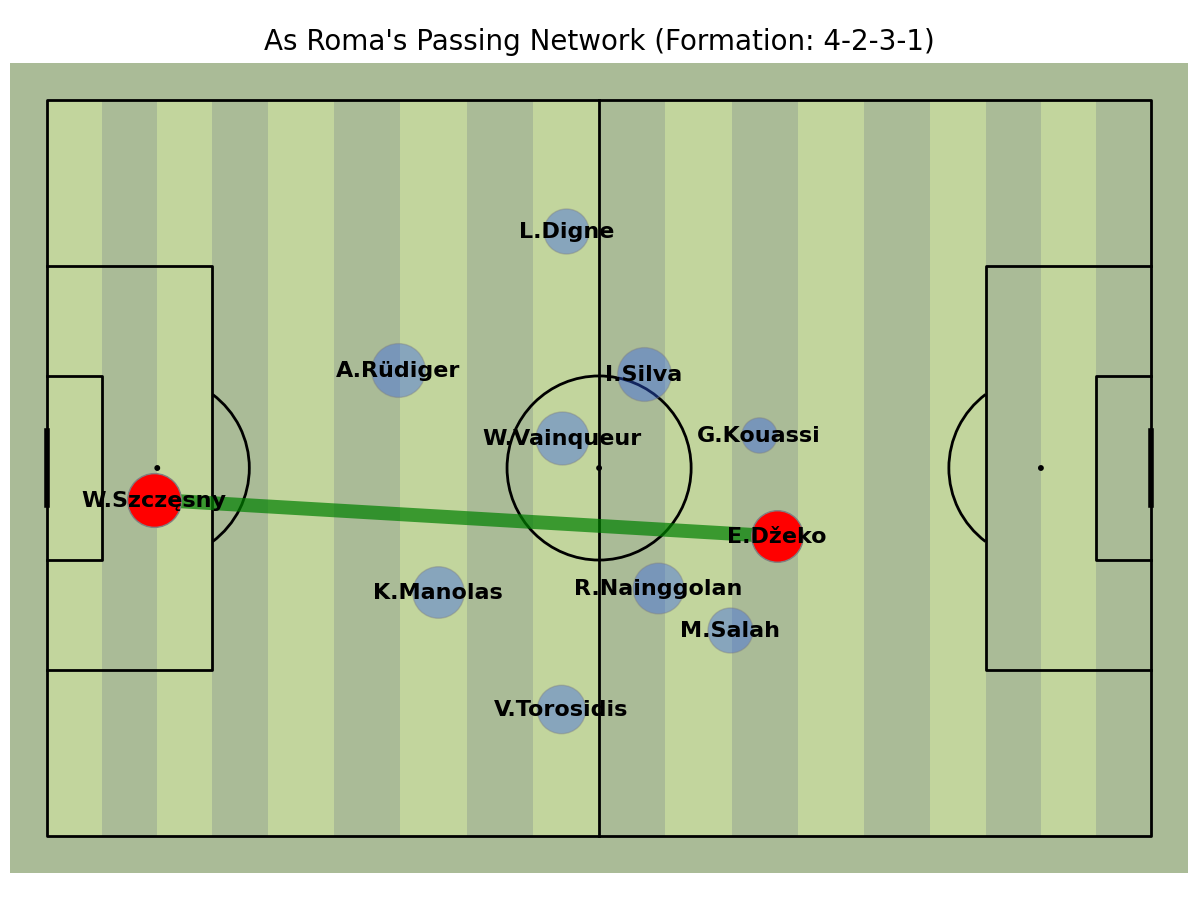

In [18]:
linesTop_df = lines_df[lines_df['pass_count']>12]
linesTop_df = linesTop_df.sort_values(by='pass_count', ascending=False)
linesTop_df

# Drawing pitch
pitch = Pitch(line_color='black', pitch_color='#aabb97', stripe_color='#c2d59d', stripe=True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Annotating player name and scatter plot for titolari
# for i, row in scatter_df.iterrows():
#     # If the player is a starter, draw a special marker
#     if row.is_starter:
#         pitch.scatter(row.x, row.y, s=row.marker_size, color='#2f5fed', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder=3)
#         short_name = row.player_name.split()[0][0] + "." + row.player_name.split()[-1]
#         pitch.annotate(short_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in scatter_df.iterrows():
    if row.is_starter:
        # Check if player has a pass connection (will be red if a line is drawn later)
        if not any(linesTop_df['pair_key'].str.contains(row.player_name)):
            color = '#2f5fed'  # Default blue color if no pass connection
            a = 0.4
        else:
            color = 'red'  # Set to red if player has at least one pass connection
            a = 1
        
        pitch.scatter(row.x, row.y, s=row.marker_size, color=color, edgecolors='grey', linewidth=1, alpha=a, ax=ax["pitch"], zorder=3)
        short_name = row.player_name.split()[0][0] + "." + row.player_name.split()[-1]
        pitch.annotate(short_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight="bold", size=16, ax=ax["pitch"], zorder=4)
    

# Loop through the passes and draw lines between players who are both present in scatter_df
for i, row in linesTop_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]

    if player1 != "" and player2 != "" and player1 in titolari and player2 in titolari:
        # Extract coordinates for player1
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]

        # Extract coordinates for player2
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]

        # Get the number of passes between the two players
        num_passes = row["pass_count"]

        # Adjust the line width based on the number of passes
        line_width = (num_passes / lines_df['pass_count'].max() * 10)

        # Draw the line between player1 and player2
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=0.7, lw=line_width, zorder=2, color="green", ax=ax["pitch"])

# Set the title of the plot
fig.suptitle(f"As Roma's Passing Network (Formation: {modulo})", fontsize=20)

# Show the plot
plt.show()
